##  Car Price Project - Algorithms

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import re
import pprint
import joblib

#pd.set_option('max_colwidth', 2000)
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

#Distributions
from scipy.stats import randint
from scipy.stats import uniform
from skopt.space import Real

#Feature selection
from eli5.sklearn import PermutationImportance
import eli5

#transformers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

#Model selection
from sklearn.base import clone
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

#Anomaly detection for outliers.
from sklearn.ensemble import IsolationForest

#Models for prediction
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import lightgbm as lgb

#Scoring
from sklearn.metrics import mean_squared_error

C:\Users\Justin\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
def one_hot_encode(train_df, test_df, cat_cols):
    '''
    One-Hot Encode train category columns.  Apply identical encoding to test.
    Unknown category for test handled by returning all zeroes column.  Function
    keeps original dataframe indices intact.
    '''
    from sklearn.preprocessing import OneHotEncoder
    ohe = OneHotEncoder(sparse=False, drop=None, handle_unknown='ignore')  #drop None or 'first'
    #ohe = OneHotEncoder(sparse=False, drop='first', handle_unknown='error')  #drop None or 'first'
    #fit_transform train cat_cols.
    ohe_train_df=pd.DataFrame(ohe.fit_transform(train_df[cat_cols]))
    ohe_train_df.index=train_df.index
    ohe_train_df.columns=ohe.get_feature_names(cat_cols)
    #Transform test.  Categories exclusive to train get zeros in test.  Categories exclusive to test are omitted.
    ohe_test_df=pd.DataFrame(ohe.transform(test_df[cat_cols]))
    ohe_test_df.index=test_df.index
    ohe_test_df.columns=ohe.get_feature_names(cat_cols)
    return ohe_train_df, ohe_test_df

In [3]:
def train_and_valid(what_model, num_folds, X, y):
    fold_rsme=[]
    kf=KFold(n_splits=num_folds, shuffle=True, random_state=30)    
        
    for train_index, valid_index in kf.split(X):
        #Clone is a model copy not yet fit on the data.  Initial conditions impact certain model results, like SGD.
        clone_model = clone(what_model)                                  
        trn_X, valid_X = X.iloc[train_index, :], X.iloc[valid_index, :]  #df has columns
        trn_y, valid_y = y.iloc[train_index], y.iloc[valid_index]        #series no columns

        clone_model.fit(trn_X, trn_y)
        valid_pred=clone_model.predict(valid_X)
        fold_rsme.append(round(np.sqrt(mean_squared_error(valid_y, valid_pred)), 3))
    return fold_rsme, clone_model

In [4]:
def query_table_to_df(dbname_string, query):  
    '''Query sqlite database and return DataFrame.'''
    with sqlite3.connect(dbname_string) as conn: # autocommit mode
        return pd.read_sql(sql=query, con=conn, index_col='index')

In [5]:
#Load data
vehicle = joblib.load('vehicle.joblib')  #contains sqlite-incompatible data
train=query_table_to_df('auto.sqlite','SELECT * from trainClean')
test=query_table_to_df('auto.sqlite','SELECT * from testClean')
train.index.name=None
test.index.name=None

In [6]:
train.shape

(3112, 14)

##  Nonlinear Models - LightGBM

### Convert categories to numbers

In [7]:
#LightGBM model: Encode train/test categories as integers.  
#https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.train.html#lightgbm.train

def encode_cat_to_int(train, test):
    cat_train = train.select_dtypes(['object'])
    if len(cat_train.columns) == 0:
        print('### No categorical features to encode. ###')
        return  #Dont overwrite train and test
    for c in cat_train.columns:
        from sklearn.preprocessing import LabelEncoder
        le=LabelEncoder()
        #Fit encoder on all possible categories in train & test
        le.fit(train[c].values.tolist() + test[c].values.tolist())
        #Return encoding to column in train and column in test.
        train[c]=le.transform(train[c].values.tolist())
        test[c]=le.transform(test[c].values.tolist())
    return train, test

#encode_cat_to_int overwrites the passed DataFrame -- use DataFrame copy instead.
train_lenc, test_lenc = encode_cat_to_int(train=train.copy(), test=test.copy())

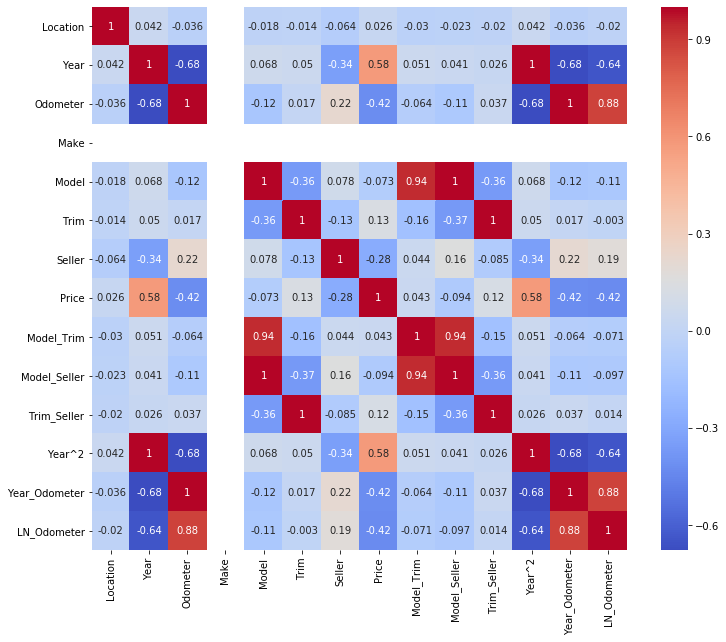

In [8]:
#Show correlation heatmap.  Keeping the collinear features may help prediction, while making the 
#linear regression coefficients less interpretable.
plt.figure(figsize=(12,10))
sns.heatmap(train_lenc.corr(), cmap='coolwarm', annot=True)
plt.show()

<a id='section_id1'></a>

### Detect Anomalies with Isolation Forest

In [9]:
train_lenc.head(1)

,Location,Year,Odometer,Make,Model,Trim,Seller,Price,Model_Trim,Model_Seller,Trim_Seller,Year^2,Year_Odometer,LN_Odometer
5764,3,2016,55843.0,0,4,24,0,25250.0,19,8,48,4064256,112579488.0,10.930299


In [10]:
def get_anomalies(train, test, drop_test_anom=True):
    '''Drop anomalies from train and test.'''
    #Instantiate, fit, and predict with Isolation Forest.
    isof = IsolationForest(n_estimators = 200, max_samples = 256, max_features=1.0, contamination=0.05, behaviour='new', n_jobs=-1, random_state=33)
    trn_preds = isof.fit_predict(train)
    tst_preds = isof.predict(test)

    #Save outliers (-1) to indexed series.
    trn_preds = pd.Series(data=trn_preds, index=train.index, name='OutlierTrn')
    trn_anom = trn_preds[trn_preds == -1]
    tst_preds = pd.Series(data=tst_preds, index=test.index, name='OutlierTst')
    tst_anom = tst_preds[tst_preds == -1]

    #Drop anomalies.
    trn_drops = trn_anom.index
    print(f'{len(trn_drops)} train anomalies flagged by Isolation Forest:', trn_drops)
        
    if drop_test_anom == True:
        tst_drops = tst_anom.index
        print(f'{len(tst_drops)} test anomalies flagged by Isolation Forest:', tst_drops)
    else:
        tst_drops = 'None_dropped'
        print(f'\nAnomaly flagging of test disabled:', tst_drops)
    return trn_drops, tst_drops

In [11]:
#Print train and test anomalies.  Assumes same contamination level.
train_anom, test_anom  = get_anomalies(train=train_lenc, test=test_lenc, drop_test_anom=True)

156 train anomalies flagged by Isolation Forest: Int64Index([1543, 1919,  357, 7203, 2005, 7373, 3103, 2798, 1017, 4800,
            ...
            7712, 1272, 5237,  169, 3629, 1120, 7017, 5883, 6479,  458],
           dtype='int64', length=156)
19 test anomalies flagged by Isolation Forest: Int64Index([ 8472, 10445,  2447,  1717,  9900, 10514,  8213,   182,  8761,
             2522,  8000,  1505,  1881,  7853,  7681,  8378,   201,  3451,
             1714],
           dtype='int64')


In [12]:
#Drop anomalies from LightGBM data.
# train_lenc.drop(index = train_anom, inplace=True, errors = 'ignore')
# test_lenc.drop(index = test_anom, inplace=True, errors = 'ignore')

In [13]:
# #Recursive feature elimination with cross-validation.  SLOW due to high feature count.
# from sklearn.feature_selection import RFECV
# orig_feat = np.array(trainX_lenc.columns)
# metrics=[]

# for alpha in [0.05, 0.1]:
#     rfecv = RFECV(estimator=Ridge(alpha=alpha), step=1, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
#     rfecv.fit(trainX_lenc,trainY)
#     metrics.append([alpha, rfecv.n_features_,min(rfecv.grid_scores_), orig_feat[~rfecv.support_]])
    
# report=pd.DataFrame(data=metrics, columns=['alpha','optimal_feat', 'min_error', 'drop_feat'])
# display(report)

# #Drop RFE features.
# RFE_drops = report.loc[1,'drop_feat']
# print('Chosen drop features:', RFE_drops)
# trainX = trainX.drop(columns=RFE_drops, axis='columns', errors='ignore')
# testX_lenc = testX_lenc.drop(columns=RFE_drops, axis='columns', errors='ignore')

### LightGBM with label encoding

In [14]:
#Split out Price
trainX_lenc = train_lenc.copy()
trainY_lenc =trainX_lenc.pop('Price')
testX_lenc = test_lenc.copy()
testY_lenc = testX_lenc.pop('Price')

In [15]:
#CREATE LightGBM model with random search.

clf = lgb.LGBMRegressor(boosting_type='gbdt',
                         objective='regression',
                         n_jobs=1, 
                         silent=1)

# RandomizedSearchCV using cross-validation
param_grid={"learning_rate": Real(0.01, 1.0, 'log-uniform'),
            "n_estimators": randint(100,150),
            "num_leaves": randint(2, 600), 
            "max_depth": randint(0, 40),
            "min_data_in_leaf": randint(10, 200),  #prevents overfitting
            "max_bin": randint(100,60000),
            "bagging_fraction": Real(0.01, 0.1, 'uniform'),  #data fraction used
            "feature_fraction": uniform(0.01, 0.99),         #percent of features randomly selected for each tree
            "subsample_for_bin": randint(100000, 600000),
            "lambda_l2": Real(1e-9, 1000, 'log-uniform'),
            "lambda_l1": Real(1e-9, 1, 'log-uniform'),          
            }

#Report results for random_search.  Changed scoring from 
rs_cv = RandomizedSearchCV(clf, param_distributions=param_grid,\
                                   n_iter=30, n_jobs=-1, cv=10, scoring='neg_mean_absolute_error',\
                                   iid=False, return_train_score=False,random_state=40)

#RUN model.
rs_cv.fit(trainX_lenc, trainY_lenc)

#SCORE model.
best_score = rs_cv.best_score_
best_score_std = rs_cv.cv_results_['std_test_score'][rs_cv.best_index_]
best_params = rs_cv.best_params_
print(f'## Grid iters checked: {len(rs_cv.cv_results_["params"])}')
print(f'## best CV score: {best_score:.4f} +- {best_score_std:.4f}\n')
print('## Best parameters:')
pprint.pprint(best_params)

## Grid iters checked: 30
## best CV score: -2814.5064 +- 102.5420

## Best parameters:
{'bagging_fraction': array([0.06267572]),
 'feature_fraction': 0.8449265515495977,
 'lambda_l1': array([0.00191179]),
 'lambda_l2': array([0.03977551]),
 'learning_rate': array([0.15483176]),
 'max_bin': 32602,
 'max_depth': 37,
 'min_data_in_leaf': 95,
 'n_estimators': 125,
 'num_leaves': 176,
 'subsample_for_bin': 325177}


In [16]:
#PREDICT model.
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
y_predictions = rs_cv.predict(testX_lenc)
print('test R^2:', round(r2_score(testY_lenc, y_predictions),4))
print('test MAE:', round(mean_absolute_error(testY_lenc, y_predictions),0))

test R^2: 0.884
test MAE: 2393.0


In [17]:
rs_cv.best_params_

{'bagging_fraction': array([0.06267572]),
 'feature_fraction': 0.8449265515495977,
 'lambda_l1': array([0.00191179]),
 'lambda_l2': array([0.03977551]),
 'learning_rate': array([0.15483176]),
 'max_bin': 32602,
 'max_depth': 37,
 'min_data_in_leaf': 95,
 'n_estimators': 125,
 'num_leaves': 176,
 'subsample_for_bin': 325177}

In [18]:
#Get feature importances using eli5.
perm = PermutationImportance(rs_cv,n_iter=5).fit(testX_lenc, testY_lenc)
eli5.show_weights(perm, feature_names = testX_lenc.columns.tolist())

Weight,Feature
4868.0938 ± 48.7677,Model
3105.7035 ± 300.2013,Year
1671.9126 ± 148.0239,Model_Trim
1033.7314 ± 139.4933,Odometer
978.1679 ± 200.8435,Year^2
601.9898 ± 197.7563,Trim_Seller
368.4129 ± 82.9092,Trim
158.6094 ± 33.1725,Year_Odometer
135.4335 ± 58.8664,Seller
87.5196 ± 20.0047,Model_Seller


In [19]:
# #Get feature importances for LGB per Rahul Agarwal
# from sklearn.metrics import mean_absolute_error
# def score(X,y):
#     y_pred=rs_cv.predict(X)
#     return round(mean_absolute_error(y, y_pred),0)

# from eli5.permutation_importance import get_score_importances
# base_score, score_decreases = get_score_importances(score, np.array(trainX_lenc), trainY_lenc)
# feature_importances = np.mean(score_decreases, axis=0)

# feature_importance_dict = {}
# for i, feature_name in enumerate(trainX_lenc.columns):
#     feature_importance_dict[feature_name]=feature_importances[i]
# print(dict(sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=False)[:10]))

#### Residuals Plot - format explanation: http://www.win-vector.com/blog/2019/09/why-do-we-plot-predictions-on-the-x-axis/

In [20]:
def plot_residuals(predicted, true):
    '''
    Plots predicted vs error.  Error = true - predicted.  Marks
    three standard deviation error from mean with orange bars.  
    Plots histogram.  Prints error statistics.
    '''
    error = true - predicted
    print('error count:', len(error), '| error avg:', round(error.mean(),1), '| high pred percent:', round(100*len(error[error<0])/len(error),1), '| low pred percent:', round(100*len(error[error>=0])/len(error),1), )
    mean = np.mean(error)
    z=(error-mean)/np.std(error)
    three_std = 3* np.std(error)
    upper_lim = mean + three_std
    lower_lim = mean - three_std
    fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10,30))
    sns.set(font_scale=1.3)
    sns.scatterplot(x=predicted, y=error, ax=ax1, color='black')    
    ax1.set_title('Scatterplot: Predicted vs Error')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Error - True less Predicted')
    ax1.axhline(y=0, color='g', ls='--', alpha=0.8)
    ax1.axhline(y=upper_lim, color='orange', ls='--', alpha=0.8)
    ax1.axhline(y=lower_lim, color='orange', ls='--', alpha=0.8)
    
    for elem in range(0, predicted.shape[0]):  #add iloc for error outside limits. 's=' is the text string.
        x_val = predicted[elem]     #assume predicted is numpy.ndarray
        y_val = error.values[elem]  #assume error is Series
        label_str = str(elem)       #iloc
        if (y_val > upper_lim or y_val < lower_lim):        
            ax1.text(x=x_val+500, y=y_val-400, s=label_str, horizontalalignment = 'left', size=14, color='r')
    
    sns.distplot(error, ax=ax2, kde=True)
    ax2.set_title('Histogram: Error - True Less Predicted')
    ax2.set_xlabel('Error')
    ax2.set_ylabel('Frequency')
    ax2.axvline(x=0, color='black', ls='--', alpha=0.8)
    
    sns.regplot(x=predicted, y=true, ax=ax3, color='black', marker='.', ci=None)
    ax3.set_title('Linear Regression Plot: Predicted vs True')
    ax3.set_xlabel('Predicted')
    ax3.set_ylabel('True')

error count: 346 | error avg: -111.5 | high pred percent: 50.6 | low pred percent: 49.4


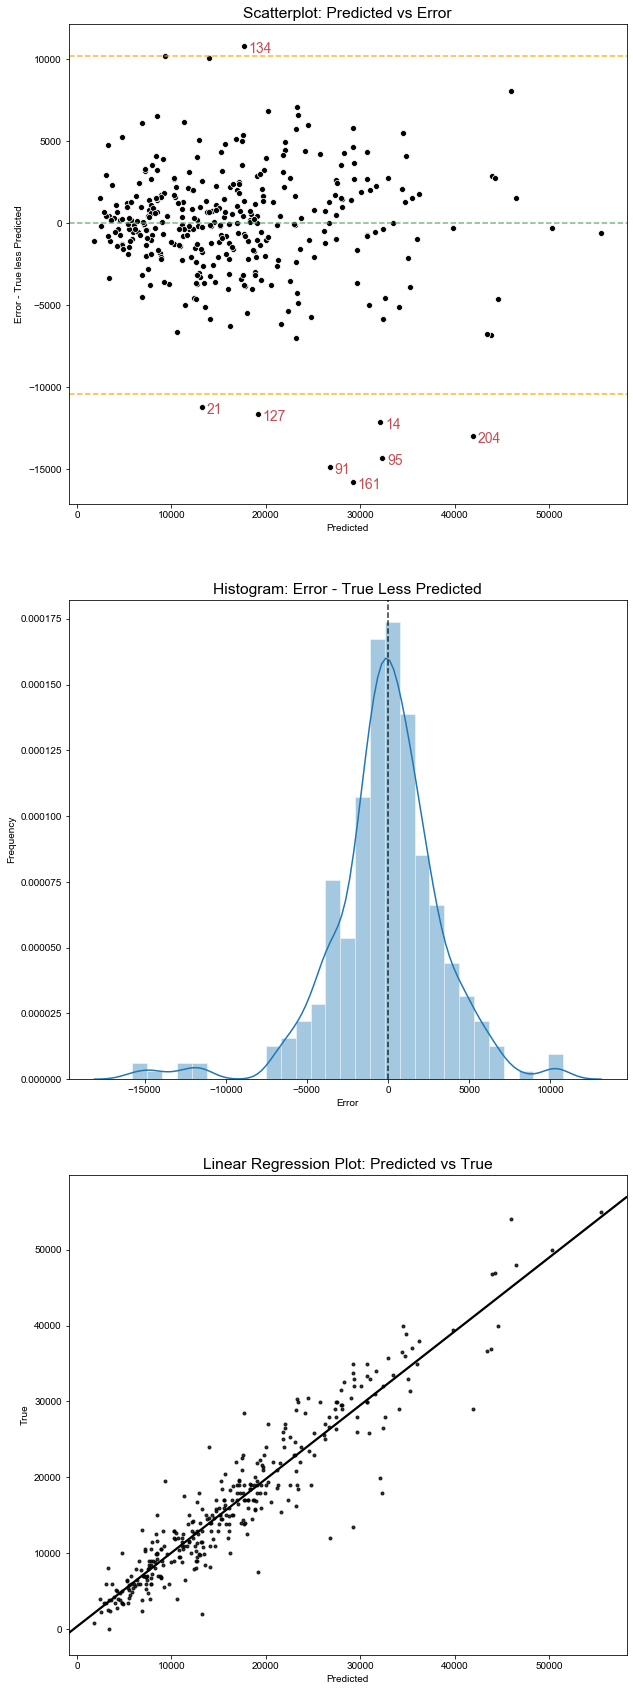

In [21]:
plot_residuals(predicted=y_predictions, true=testY_lenc)

## DEBUG OUTLIERS

In [22]:
# #Review iloc
# pd.set_option('max_colwidth', 100)
# for inum in [19,465,232]:
#     display('### modeled test:', test.iloc[[inum]])
#     print('predicted:', y_predictions[inum])
#     print('error:', testY.iloc[inum] - y_predictions[inum])
#     display('### original:', vehicle.loc[[test.iloc[inum:inum+1].index[0]]])
#     print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')

In [23]:
# #Examples in train
# train[(train['Year'] == 2017) & (train['Model'] == 'f-350') & (train['Trim'] == 'super')]

In [24]:
# #Examples in vehicle
# vehicle[(vehicle['Year'] == 2005) & (vehicle['Model'] == 'mustang') & (vehicle['Trim'] == 'None')]

In [25]:
# pd.set_option('max_colwidth', 100)
# vehicle.loc[[5053, 4637, 4934,6459]]

## Linear Model data

In [26]:
train=query_table_to_df('auto.sqlite','SELECT * from trainClean')
test=query_table_to_df('auto.sqlite','SELECT * from testClean')
train.index.name=None
test.index.name=None
train.shape

(3112, 14)

In [27]:
#Drop Isolation Forest anomalies from regression data.
# train.drop(index = train_anom, inplace=True, errors = 'ignore')
# test.drop(index = test_anom, inplace=True, errors = 'ignore')

[Go To Isolation Forest](#section_id1)

In [28]:
#Split out Price
trainX = train.copy()
trainY =trainX.pop('Price')
testX = test.copy()
testY = testX.pop('Price')

In [29]:
trainX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3112 entries, 5764 to 9220
Data columns (total 13 columns):
Location         3112 non-null object
Year             3112 non-null int64
Odometer         3112 non-null float64
Make             3112 non-null object
Model            3112 non-null object
Trim             3112 non-null object
Seller           3112 non-null object
Model_Trim       3112 non-null object
Model_Seller     3112 non-null object
Trim_Seller      3112 non-null object
Year^2           3112 non-null int64
Year_Odometer    3112 non-null float64
LN_Odometer      3112 non-null float64
dtypes: float64(3), int64(2), object(8)
memory usage: 340.4+ KB


### One-Hot Encode

In [30]:
#Get One-Hot columns for the specified categ_columns.
categ_cols= trainX.select_dtypes('object').columns.values
ohe_train_df, ohe_test_df = one_hot_encode(train_df=trainX, test_df=testX, cat_cols=categ_cols)

In [31]:
print(ohe_train_df.shape)
ohe_train_df.head(2)

(3112, 157)


,Location_austin,Location_dallas,Location_elpaso,Location_houston,Location_sanantonio,Make_ford,Model_edge,Model_escape,Model_expedition,Model_explorer,Model_f-150,Model_f-250,Model_f-350,Model_fiesta,Model_focus,Model_fusion,Model_mustang,Model_transit,Trim_4x4,Trim_cargo,Trim_connect,Trim_convertible,Trim_coupe,Trim_diesel,Trim_ecoboost,Trim_eddie,Trim_edge,Trim_fx2,Trim_fx4,Trim_gt,Trim_king,Trim_lariat,Trim_limited,Trim_platinum,Trim_se,Trim_sport,Trim_super,Trim_super duty,Trim_supercab,Trim_supercrew,Trim_titanium,Trim_xl,Trim_xlt,Seller_dealer,Seller_owner,Model_Trim_edge_edge,Model_Trim_escape_se,Model_Trim_escape_titanium,Model_Trim_expedition_eddie,Model_Trim_expedition_limited,Model_Trim_expedition_xlt,Model_Trim_explorer_limited,Model_Trim_explorer_sport,Model_Trim_explorer_xlt,Model_Trim_f-150_4x4,Model_Trim_f-150_fx2,Model_Trim_f-150_fx4,Model_Trim_f-150_king,Model_Trim_f-150_lariat,Model_Trim_f-150_platinum,Model_Trim_f-150_super,Model_Trim_f-150_supercab,Model_Trim_f-150_supercrew,Model_Trim_f-150_xl,Model_Trim_f-150_xlt,Model_Trim_f-250_diesel,Model_Trim_f-250_king,Model_Trim_f-250_lariat,Model_Trim_f-250_super,Model_Trim_f-250_super duty,Model_Trim_f-250_xlt,Model_Trim_f-350_super,Model_Trim_f-350_super duty,Model_Trim_fiesta_se,Model_Trim_focus_se,Model_Trim_fusion_se,Model_Trim_fusion_titanium,Model_Trim_mustang_convertible,Model_Trim_mustang_coupe,Model_Trim_mustang_ecoboost,Model_Trim_mustang_gt,Model_Trim_transit_cargo,Model_Trim_transit_connect,Model_Seller_edge_dealer,Model_Seller_edge_owner,Model_Seller_escape_dealer,Model_Seller_escape_owner,Model_Seller_expedition_dealer,Model_Seller_expedition_owner,Model_Seller_explorer_dealer,Model_Seller_explorer_owner,Model_Seller_f-150_dealer,Model_Seller_f-150_owner,Model_Seller_f-250_dealer,Model_Seller_f-250_owner,Model_Seller_f-350_dealer,Model_Seller_f-350_owner,Model_Seller_fiesta_dealer,Model_Seller_fiesta_owner,Model_Seller_focus_dealer,Model_Seller_focus_owner,Model_Seller_fusion_dealer,Model_Seller_fusion_owner,Model_Seller_mustang_dealer,Model_Seller_mustang_owner,Model_Seller_transit_dealer,Model_Seller_transit_owner,Trim_Seller_4x4_dealer,Trim_Seller_4x4_owner,Trim_Seller_cargo_dealer,Trim_Seller_cargo_owner,Trim_Seller_connect_dealer,Trim_Seller_connect_owner,Trim_Seller_convertible_dealer,Trim_Seller_convertible_owner,Trim_Seller_coupe_dealer,Trim_Seller_coupe_owner,Trim_Seller_diesel_dealer,Trim_Seller_diesel_owner,Trim_Seller_ecoboost_dealer,Trim_Seller_ecoboost_owner,Trim_Seller_eddie_dealer,Trim_Seller_eddie_owner,Trim_Seller_edge_dealer,Trim_Seller_edge_owner,Trim_Seller_fx2_dealer,Trim_Seller_fx2_owner,Trim_Seller_fx4_dealer,Trim_Seller_fx4_owner,Trim_Seller_gt_dealer,Trim_Seller_gt_owner,Trim_Seller_king_dealer,Trim_Seller_king_owner,Trim_Seller_lariat_dealer,Trim_Seller_lariat_owner,Trim_Seller_limited_dealer,Trim_Seller_limited_owner,Trim_Seller_platinum_dealer,Trim_Seller_platinum_owner,Trim_Seller_se_dealer,Trim_Seller_se_owner,Trim_Seller_sport_dealer,Trim_Seller_sport_owner,Trim_Seller_super duty_dealer,Trim_Seller_super duty_owner,Trim_Seller_super_dealer,Trim_Seller_super_owner,Trim_Seller_supercab_dealer,Trim_Seller_supercab_owner,Trim_Seller_supercrew_dealer,Trim_Seller_supercrew_owner,Trim_Seller_titanium_dealer,Trim_Seller_titanium_owner,Trim_Seller_xl_dealer,Trim_Seller_xl_owner,Trim_Seller_xlt_dealer,Trim_Seller_xlt_owner
5764,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [32]:
#Drop original category columns.  Concatenate the One-Hot columns.
trainX = trainX.drop(columns=categ_cols, axis='columns', errors='ignore')
testX = testX.drop(columns=categ_cols, axis='columns', errors='ignore')

trainX = pd.concat([trainX, ohe_train_df], axis='columns')
testX = pd.concat([testX, ohe_test_df], axis='columns')
display('trainX:', trainX.head(2))
display('testX:', testX.head(2))

'trainX:'

,Year,Odometer,Year^2,Year_Odometer,LN_Odometer,Location_austin,Location_dallas,Location_elpaso,Location_houston,Location_sanantonio,Make_ford,Model_edge,Model_escape,Model_expedition,Model_explorer,Model_f-150,Model_f-250,Model_f-350,Model_fiesta,Model_focus,Model_fusion,Model_mustang,Model_transit,Trim_4x4,Trim_cargo,Trim_connect,Trim_convertible,Trim_coupe,Trim_diesel,Trim_ecoboost,Trim_eddie,Trim_edge,Trim_fx2,Trim_fx4,Trim_gt,Trim_king,Trim_lariat,Trim_limited,Trim_platinum,Trim_se,Trim_sport,Trim_super,Trim_super duty,Trim_supercab,Trim_supercrew,Trim_titanium,Trim_xl,Trim_xlt,Seller_dealer,Seller_owner,Model_Trim_edge_edge,Model_Trim_escape_se,Model_Trim_escape_titanium,Model_Trim_expedition_eddie,Model_Trim_expedition_limited,Model_Trim_expedition_xlt,Model_Trim_explorer_limited,Model_Trim_explorer_sport,Model_Trim_explorer_xlt,Model_Trim_f-150_4x4,Model_Trim_f-150_fx2,Model_Trim_f-150_fx4,Model_Trim_f-150_king,Model_Trim_f-150_lariat,Model_Trim_f-150_platinum,Model_Trim_f-150_super,Model_Trim_f-150_supercab,Model_Trim_f-150_supercrew,Model_Trim_f-150_xl,Model_Trim_f-150_xlt,Model_Trim_f-250_diesel,Model_Trim_f-250_king,Model_Trim_f-250_lariat,Model_Trim_f-250_super,Model_Trim_f-250_super duty,Model_Trim_f-250_xlt,Model_Trim_f-350_super,Model_Trim_f-350_super duty,Model_Trim_fiesta_se,Model_Trim_focus_se,Model_Trim_fusion_se,Model_Trim_fusion_titanium,Model_Trim_mustang_convertible,Model_Trim_mustang_coupe,Model_Trim_mustang_ecoboost,Model_Trim_mustang_gt,Model_Trim_transit_cargo,Model_Trim_transit_connect,Model_Seller_edge_dealer,Model_Seller_edge_owner,Model_Seller_escape_dealer,Model_Seller_escape_owner,Model_Seller_expedition_dealer,Model_Seller_expedition_owner,Model_Seller_explorer_dealer,Model_Seller_explorer_owner,Model_Seller_f-150_dealer,Model_Seller_f-150_owner,Model_Seller_f-250_dealer,Model_Seller_f-250_owner,Model_Seller_f-350_dealer,Model_Seller_f-350_owner,Model_Seller_fiesta_dealer,Model_Seller_fiesta_owner,Model_Seller_focus_dealer,Model_Seller_focus_owner,Model_Seller_fusion_dealer,Model_Seller_fusion_owner,Model_Seller_mustang_dealer,Model_Seller_mustang_owner,Model_Seller_transit_dealer,Model_Seller_transit_owner,Trim_Seller_4x4_dealer,Trim_Seller_4x4_owner,Trim_Seller_cargo_dealer,Trim_Seller_cargo_owner,Trim_Seller_connect_dealer,Trim_Seller_connect_owner,Trim_Seller_convertible_dealer,Trim_Seller_convertible_owner,Trim_Seller_coupe_dealer,Trim_Seller_coupe_owner,Trim_Seller_diesel_dealer,Trim_Seller_diesel_owner,Trim_Seller_ecoboost_dealer,Trim_Seller_ecoboost_owner,Trim_Seller_eddie_dealer,Trim_Seller_eddie_owner,Trim_Seller_edge_dealer,Trim_Seller_edge_owner,Trim_Seller_fx2_dealer,Trim_Seller_fx2_owner,Trim_Seller_fx4_dealer,Trim_Seller_fx4_owner,Trim_Seller_gt_dealer,Trim_Seller_gt_owner,Trim_Seller_king_dealer,Trim_Seller_king_owner,Trim_Seller_lariat_dealer,Trim_Seller_lariat_owner,Trim_Seller_limited_dealer,Trim_Seller_limited_owner,Trim_Seller_platinum_dealer,Trim_Seller_platinum_owner,Trim_Seller_se_dealer,Trim_Seller_se_owner,Trim_Seller_sport_dealer,Trim_Seller_sport_owner,Trim_Seller_super duty_dealer,Trim_Seller_super duty_owner,Trim_Seller_super_dealer,Trim_Seller_super_owner,Trim_Seller_supercab_dealer,Trim_Seller_supercab_owner,Trim_Seller_supercrew_dealer,Trim_Seller_supercrew_owner,Trim_Seller_titanium_dealer,Trim_Seller_titanium_owner,Trim_Seller_xl_dealer,Trim_Seller_xl_owner,Trim_Seller_xlt_dealer,Trim_Seller_xlt_owner
5764,2016,55843.0,4064256,112579488.0,10.930299,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

'testX:'

,Year,Odometer,Year^2,Year_Odometer,LN_Odometer,Location_austin,Location_dallas,Location_elpaso,Location_houston,Location_sanantonio,Make_ford,Model_edge,Model_escape,Model_expedition,Model_explorer,Model_f-150,Model_f-250,Model_f-350,Model_fiesta,Model_focus,Model_fusion,Model_mustang,Model_transit,Trim_4x4,Trim_cargo,Trim_connect,Trim_convertible,Trim_coupe,Trim_diesel,Trim_ecoboost,Trim_eddie,Trim_edge,Trim_fx2,Trim_fx4,Trim_gt,Trim_king,Trim_lariat,Trim_limited,Trim_platinum,Trim_se,Trim_sport,Trim_super,Trim_super duty,Trim_supercab,Trim_supercrew,Trim_titanium,Trim_xl,Trim_xlt,Seller_dealer,Seller_owner,Model_Trim_edge_edge,Model_Trim_escape_se,Model_Trim_escape_titanium,Model_Trim_expedition_eddie,Model_Trim_expedition_limited,Model_Trim_expedition_xlt,Model_Trim_explorer_limited,Model_Trim_explorer_sport,Model_Trim_explorer_xlt,Model_Trim_f-150_4x4,Model_Trim_f-150_fx2,Model_Trim_f-150_fx4,Model_Trim_f-150_king,Model_Trim_f-150_lariat,Model_Trim_f-150_platinum,Model_Trim_f-150_super,Model_Trim_f-150_supercab,Model_Trim_f-150_supercrew,Model_Trim_f-150_xl,Model_Trim_f-150_xlt,Model_Trim_f-250_diesel,Model_Trim_f-250_king,Model_Trim_f-250_lariat,Model_Trim_f-250_super,Model_Trim_f-250_super duty,Model_Trim_f-250_xlt,Model_Trim_f-350_super,Model_Trim_f-350_super duty,Model_Trim_fiesta_se,Model_Trim_focus_se,Model_Trim_fusion_se,Model_Trim_fusion_titanium,Model_Trim_mustang_convertible,Model_Trim_mustang_coupe,Model_Trim_mustang_ecoboost,Model_Trim_mustang_gt,Model_Trim_transit_cargo,Model_Trim_transit_connect,Model_Seller_edge_dealer,Model_Seller_edge_owner,Model_Seller_escape_dealer,Model_Seller_escape_owner,Model_Seller_expedition_dealer,Model_Seller_expedition_owner,Model_Seller_explorer_dealer,Model_Seller_explorer_owner,Model_Seller_f-150_dealer,Model_Seller_f-150_owner,Model_Seller_f-250_dealer,Model_Seller_f-250_owner,Model_Seller_f-350_dealer,Model_Seller_f-350_owner,Model_Seller_fiesta_dealer,Model_Seller_fiesta_owner,Model_Seller_focus_dealer,Model_Seller_focus_owner,Model_Seller_fusion_dealer,Model_Seller_fusion_owner,Model_Seller_mustang_dealer,Model_Seller_mustang_owner,Model_Seller_transit_dealer,Model_Seller_transit_owner,Trim_Seller_4x4_dealer,Trim_Seller_4x4_owner,Trim_Seller_cargo_dealer,Trim_Seller_cargo_owner,Trim_Seller_connect_dealer,Trim_Seller_connect_owner,Trim_Seller_convertible_dealer,Trim_Seller_convertible_owner,Trim_Seller_coupe_dealer,Trim_Seller_coupe_owner,Trim_Seller_diesel_dealer,Trim_Seller_diesel_owner,Trim_Seller_ecoboost_dealer,Trim_Seller_ecoboost_owner,Trim_Seller_eddie_dealer,Trim_Seller_eddie_owner,Trim_Seller_edge_dealer,Trim_Seller_edge_owner,Trim_Seller_fx2_dealer,Trim_Seller_fx2_owner,Trim_Seller_fx4_dealer,Trim_Seller_fx4_owner,Trim_Seller_gt_dealer,Trim_Seller_gt_owner,Trim_Seller_king_dealer,Trim_Seller_king_owner,Trim_Seller_lariat_dealer,Trim_Seller_lariat_owner,Trim_Seller_limited_dealer,Trim_Seller_limited_owner,Trim_Seller_platinum_dealer,Trim_Seller_platinum_owner,Trim_Seller_se_dealer,Trim_Seller_se_owner,Trim_Seller_sport_dealer,Trim_Seller_sport_owner,Trim_Seller_super duty_dealer,Trim_Seller_super duty_owner,Trim_Seller_super_dealer,Trim_Seller_super_owner,Trim_Seller_supercab_dealer,Trim_Seller_supercab_owner,Trim_Seller_supercrew_dealer,Trim_Seller_supercrew_owner,Trim_Seller_titanium_dealer,Trim_Seller_titanium_owner,Trim_Seller_xl_dealer,Trim_Seller_xl_owner,Trim_Seller_xlt_dealer,Trim_Seller_xlt_owner
1832,2010,155000.0,4040100,311550000.0,11.951180,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [33]:
#Review noise features - where one category is nearly all observations.

noise_feat = []
pct_zeros = .9999
for i in trainX.columns:
    counts = trainX[i].value_counts()
    zeros = counts.iloc[0]  #top frequency category    
    if zeros / len(trainX) > pct_zeros:
        noise_feat.append(i)

print(f'### {len(noise_feat)} Noise Features at {pct_zeros} pct zeros cutoff:  ###')
print(f'### Noise Features: {noise_feat}  ###\n')

# for c in trainX.columns:
#     counts = trainX[c].value_counts()
#     zeros = counts.iloc[0]  #top frequency category
#     print('Count nonzero -', (len(trainX[c]) - zeros),':')
#     plt.figure(figsize=[4,4])
#     plt.scatter(trainX[c], trainY)
#     plt.title(f'{c} vs Price'); plt.xlabel(f'{c}'); plt.ylabel('Price');
#     plt.show()

#Drop noise features for regressions.  Will help non-regularized models by reducing dimensionality.
trainX = trainX.drop(columns=noise_feat, axis='columns', errors='ignore')
testX = testX.drop(columns=noise_feat, axis='columns', errors='ignore')
print(f'### Dropped the following {len(noise_feat)} invariant noise features:', noise_feat, '###')

### 1 Noise Features at 0.9999 pct zeros cutoff:  ###
### Noise Features: ['Make_ford']  ###

### Dropped the following 1 invariant noise features: ['Make_ford'] ###


## `Tune Linear Models with Cross Validation`

In [34]:
#Train and Score LR CV
lr=LinearRegression(fit_intercept=True)
fold_rsme, linMod = train_and_valid(what_model=lr, num_folds=10, X=trainX, y=trainY)
print('Fold RSME:', fold_rsme)
print('## Avg RMSE:', round(np.mean(fold_rsme),4),'+-', round(np.std(fold_rsme),4))
print('## LR R^2:', round(linMod.score(trainX, trainY),3))

Fold RSME: [5593.044, 4824.926, 4897.014, 5651.572, 5291.95, 5139.629, 5585.899, 5492.117, 4582.035, 4895.268]
## Avg RMSE: 5195.3454 +- 362.1819
## LR R^2: 0.807


In [35]:
#Get LinearRegression feature importances.  Note: collinearity distorts feature importances.
perm = PermutationImportance(linMod,n_iter=2).fit(trainX, trainY)
eli5.show_weights(perm, feature_names = trainX.columns.tolist())

Weight,Feature
31387.7300 ± 206.0058,Year^2
31210.3184 ± 132.3205,Year
47.5102 ± 1.2284,Odometer
44.5224 ± 0.7916,Year_Odometer
0.0765 ± 0.0048,Model_f-250
0.0350 ± 0.0001,Trim_se
0.0209 ± 0.0009,Trim_Seller_super duty_dealer
0.0205 ± 0.0032,Trim_Seller_se_dealer
0.0194 ± 0.0018,Model_Seller_f-250_dealer
0.0193 ± 0.0014,Model_f-350


In [36]:
#Train and Score Ridge CV
import warnings
warnings.simplefilter('ignore')  #turn off warnings

ridge=Ridge(alpha=0.1, solver='cholesky')
fold_rsme, ridgeMod = train_and_valid(what_model=ridge, num_folds=10, X=trainX, y=trainY)
print('Fold RSME:', fold_rsme)
print('## Avg RMSE:', round(np.mean(fold_rsme),4),'+-', round(np.std(fold_rsme),4))
print('## ridge R^2:', round(ridgeMod.score(trainX, trainY),3))

warnings.simplefilter('default')  #turn off warnings

Fold RSME: [5697.425, 4890.785, 4961.617, 5739.096, 5404.833, 5171.446, 5793.368, 5537.989, 4516.697, 5124.445]
## Avg RMSE: 5283.7701 +- 400.2534
## ridge R^2: 0.8


## `Linear Model Predictions - Fit on 100% of train`

In [37]:
linregr=LinearRegression(fit_intercept=True)  #no scaling required for closed-form solution
linregr.fit(trainX, trainY)
y_pred_linregr=linregr.predict(testX)
RMSE = rmse=round(np.sqrt(mean_squared_error(testY, y_pred_linregr)), 4)
print('test RMSE:', RMSE)
print('test R^2 test:', round(linregr.score(testX, testY),4))
print('test MAE:', round(mean_absolute_error(testY, y_pred_linregr),0))

test RMSE: 4443.4075
test R^2 test: 0.8058
test MAE: 3227.0


In [38]:
#Examples in train
train[(train['Year'] > 1999) & (train['Model'] == 'f-150') & (train['Trim'] == 'cargo')]

,Location,Year,Odometer,Make,Model,Trim,Seller,Price,Model_Trim,Model_Seller,Trim_Seller,Year^2,Year_Odometer,LN_Odometer


In [39]:
test[(test['Year'] == 2004) & (test['Model'] == 'f-150') & (test['Trim'] == 'cargo')]

,Location,Year,Odometer,Make,Model,Trim,Seller,Price,Model_Trim,Model_Seller,Trim_Seller,Year^2,Year_Odometer,LN_Odometer


In [40]:
# #Review iloc
# pd.set_option('max_colwidth', 100)
# for inum in [370,358]:
#     display('### modeled test:', test.iloc[[inum]])
#     print('predicted:', y_pred_linregr[inum])
#     print('error:', testY.iloc[inum] - y_pred_linregr[inum])
#     display('### original:', vehicle.loc[[test.iloc[inum:inum+1].index[0]]])
#     print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')

error count: 346 | error avg: -168.7 | high pred percent: 53.2 | low pred percent: 46.8


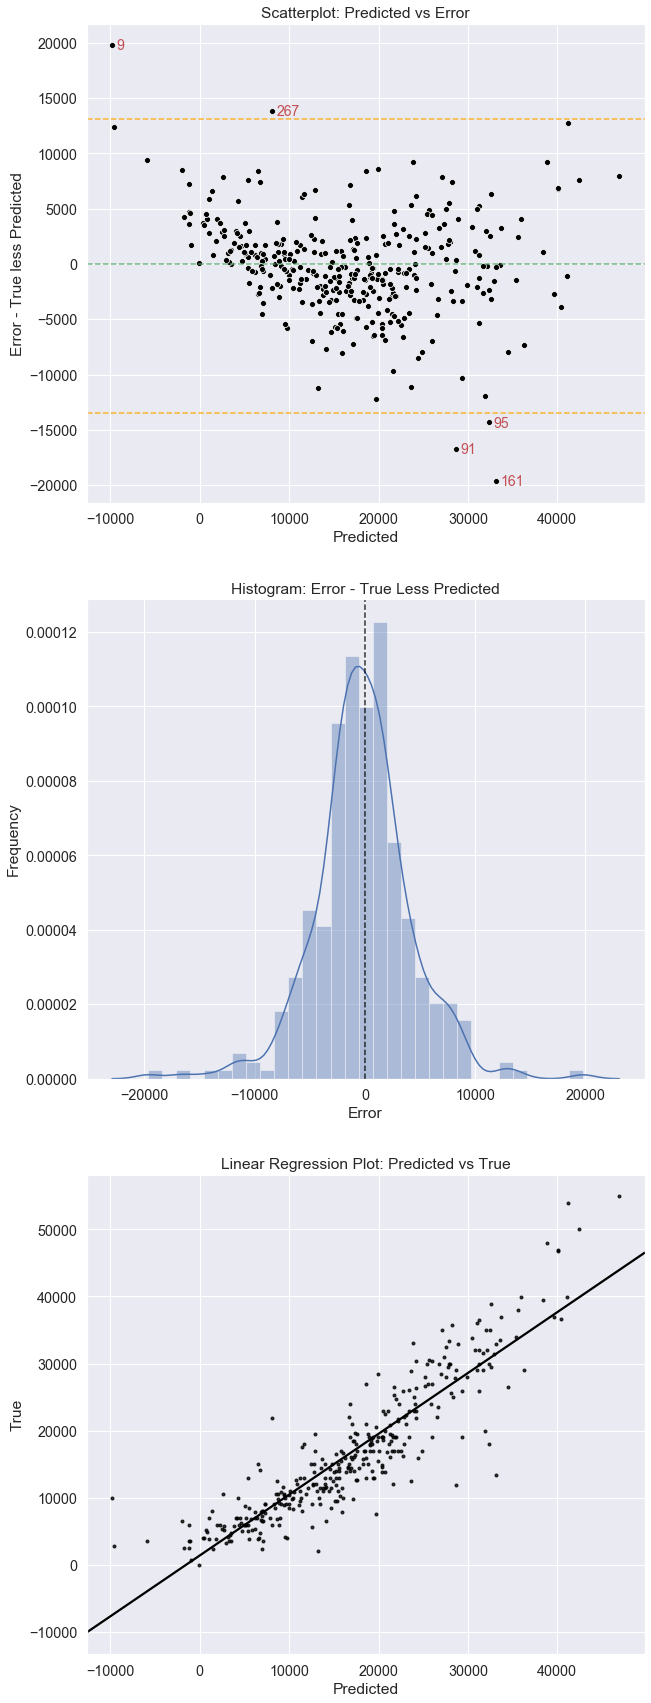

In [41]:
plot_residuals(predicted=y_pred_linregr, true=testY)

In [42]:
rr=Ridge(alpha=0.1, solver='cholesky')  #no scaling required for closed-form solution
rr.fit(trainX, trainY)
y_pred_rr=rr.predict(testX)
RMSE = rmse=round(np.sqrt(mean_squared_error(testY, y_pred_rr)), 4)
print('test RMSE:', RMSE)
print('test R^2:', round(rr.score(testX, testY),4))
print('test MAE:', round(mean_absolute_error(testY, y_pred_rr),0))

test RMSE: 4620.296
test R^2: 0.79
test MAE: 3253.0


C:\Users\Justin\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.58064e-22): result may not be accurate.
  overwrite_a=True).T


error count: 346 | error avg: -90.7 | high pred percent: 52.9 | low pred percent: 47.1


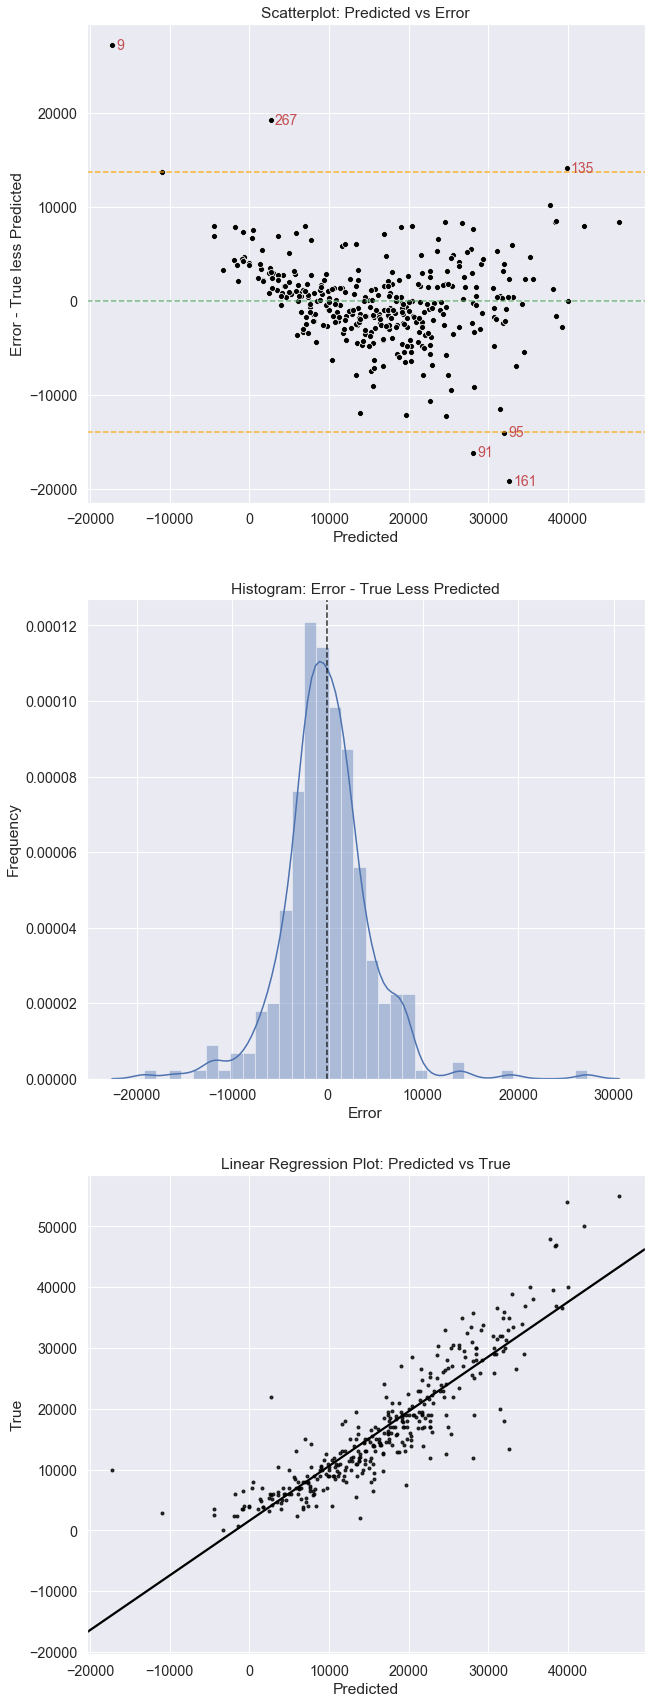

In [43]:
plot_residuals(predicted=y_pred_rr, true=testY)

In [44]:
#Row to Column ratios.
print('train shape:', trainX.shape, '| row/col ratio:', round(trainX.shape[0]/trainX.shape[1],1))
print('test shape:', testX.shape, '| row/col ratio:', round(testX.shape[0]/testX.shape[1],1))

train shape: (3112, 161) | row/col ratio: 19.3
test shape: (346, 161) | row/col ratio: 2.1


In [45]:
trainX.head()

,Year,Odometer,Year^2,Year_Odometer,LN_Odometer,Location_austin,Location_dallas,Location_elpaso,Location_houston,Location_sanantonio,Model_edge,Model_escape,Model_expedition,Model_explorer,Model_f-150,Model_f-250,Model_f-350,Model_fiesta,Model_focus,Model_fusion,Model_mustang,Model_transit,Trim_4x4,Trim_cargo,Trim_connect,Trim_convertible,Trim_coupe,Trim_diesel,Trim_ecoboost,Trim_eddie,Trim_edge,Trim_fx2,Trim_fx4,Trim_gt,Trim_king,Trim_lariat,Trim_limited,Trim_platinum,Trim_se,Trim_sport,Trim_super,Trim_super duty,Trim_supercab,Trim_supercrew,Trim_titanium,Trim_xl,Trim_xlt,Seller_dealer,Seller_owner,Model_Trim_edge_edge,Model_Trim_escape_se,Model_Trim_escape_titanium,Model_Trim_expedition_eddie,Model_Trim_expedition_limited,Model_Trim_expedition_xlt,Model_Trim_explorer_limited,Model_Trim_explorer_sport,Model_Trim_explorer_xlt,Model_Trim_f-150_4x4,Model_Trim_f-150_fx2,Model_Trim_f-150_fx4,Model_Trim_f-150_king,Model_Trim_f-150_lariat,Model_Trim_f-150_platinum,Model_Trim_f-150_super,Model_Trim_f-150_supercab,Model_Trim_f-150_supercrew,Model_Trim_f-150_xl,Model_Trim_f-150_xlt,Model_Trim_f-250_diesel,Model_Trim_f-250_king,Model_Trim_f-250_lariat,Model_Trim_f-250_super,Model_Trim_f-250_super duty,Model_Trim_f-250_xlt,Model_Trim_f-350_super,Model_Trim_f-350_super duty,Model_Trim_fiesta_se,Model_Trim_focus_se,Model_Trim_fusion_se,Model_Trim_fusion_titanium,Model_Trim_mustang_convertible,Model_Trim_mustang_coupe,Model_Trim_mustang_ecoboost,Model_Trim_mustang_gt,Model_Trim_transit_cargo,Model_Trim_transit_connect,Model_Seller_edge_dealer,Model_Seller_edge_owner,Model_Seller_escape_dealer,Model_Seller_escape_owner,Model_Seller_expedition_dealer,Model_Seller_expedition_owner,Model_Seller_explorer_dealer,Model_Seller_explorer_owner,Model_Seller_f-150_dealer,Model_Seller_f-150_owner,Model_Seller_f-250_dealer,Model_Seller_f-250_owner,Model_Seller_f-350_dealer,Model_Seller_f-350_owner,Model_Seller_fiesta_dealer,Model_Seller_fiesta_owner,Model_Seller_focus_dealer,Model_Seller_focus_owner,Model_Seller_fusion_dealer,Model_Seller_fusion_owner,Model_Seller_mustang_dealer,Model_Seller_mustang_owner,Model_Seller_transit_dealer,Model_Seller_transit_owner,Trim_Seller_4x4_dealer,Trim_Seller_4x4_owner,Trim_Seller_cargo_dealer,Trim_Seller_cargo_owner,Trim_Seller_connect_dealer,Trim_Seller_connect_owner,Trim_Seller_convertible_dealer,Trim_Seller_convertible_owner,Trim_Seller_coupe_dealer,Trim_Seller_coupe_owner,Trim_Seller_diesel_dealer,Trim_Seller_diesel_owner,Trim_Seller_ecoboost_dealer,Trim_Seller_ecoboost_owner,Trim_Seller_eddie_dealer,Trim_Seller_eddie_owner,Trim_Seller_edge_dealer,Trim_Seller_edge_owner,Trim_Seller_fx2_dealer,Trim_Seller_fx2_owner,Trim_Seller_fx4_dealer,Trim_Seller_fx4_owner,Trim_Seller_gt_dealer,Trim_Seller_gt_owner,Trim_Seller_king_dealer,Trim_Seller_king_owner,Trim_Seller_lariat_dealer,Trim_Seller_lariat_owner,Trim_Seller_limited_dealer,Trim_Seller_limited_owner,Trim_Seller_platinum_dealer,Trim_Seller_platinum_owner,Trim_Seller_se_dealer,Trim_Seller_se_owner,Trim_Seller_sport_dealer,Trim_Seller_sport_owner,Trim_Seller_super duty_dealer,Trim_Seller_super duty_owner,Trim_Seller_super_dealer,Trim_Seller_super_owner,Trim_Seller_supercab_dealer,Trim_Seller_supercab_owner,Trim_Seller_supercrew_dealer,Trim_Seller_supercrew_owner,Trim_Seller_titanium_dealer,Trim_Seller_titanium_owner,Trim_Seller_xl_dealer,Trim_Seller_xl_owner,Trim_Seller_xlt_dealer,Trim_Seller_xlt_owner
5764,2016,55843.0,4064256,112579488.0,10.930299,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

### `K-Nearest Neighbors Regressor`
##### Need Scaling

In [46]:
def scale_num_df(train_df, test_df, numer_cols, scaler):
    #fit_transform train
    scaled_trn_num_df = pd.DataFrame(scaler.fit_transform(train_df[numer_cols]))
    scaled_trn_num_df.index=train_df.index
    scaled_trn_num_df.columns=train_df[numer_cols].columns
    #display(scaled_trn_num_df.tail(2))

    #transform test
    scaled_tst_num_df = pd.DataFrame(scaler.transform(test_df[numer_cols]))
    scaled_tst_num_df.index=test_df.index
    scaled_tst_num_df.columns=test_df[numer_cols].columns
    #display(scaled_tst_num_df.head(2))
    return scaled_trn_num_df, scaled_tst_num_df

In [47]:
trainXS, testXS = scale_num_df(trainX, testX, trainX.columns, RobustScaler())
print('scaler:', RobustScaler())
print('-----------------------------------------------------------------------')

for k in range(3,11):    
    print(f'k={k}:')
    #Train and Score KNN Regressor
    knn=KNeighborsRegressor(n_neighbors=k)
    knn.fit(trainXS, trainY)

    #Predict
    y_pred_kneigh=knn.predict(testXS)
    RMSE = rmse=round(np.sqrt(mean_squared_error(testY, y_pred_kneigh)), 4)
    print('# test RMSE:', RMSE)
    print('# test R^2 test:', round(knn.score(testXS, testY),4))
    print('# test MAE:', round(mean_absolute_error(testY, y_pred_kneigh),0))
    print('-------------------------------------------------------------------\n') 

scaler: RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)
-----------------------------------------------------------------------
k=3:
# test RMSE: 4141.8995
# test R^2 test: 0.8313
# test MAE: 2853.0
-------------------------------------------------------------------

k=4:
# test RMSE: 3943.7128
# test R^2 test: 0.847
# test MAE: 2751.0
-------------------------------------------------------------------

k=5:
# test RMSE: 3904.4605
# test R^2 test: 0.8501
# test MAE: 2786.0
-------------------------------------------------------------------

k=6:
# test RMSE: 3838.1148
# test R^2 test: 0.8551
# test MAE: 2748.0
-------------------------------------------------------------------

k=7:
# test RMSE: 3916.7298
# test R^2 test: 0.8491
# test MAE: 2779.0
-------------------------------------------------------------------

k=8:
# test RMSE: 3923.3978
# test R^2 test: 0.8486
# test MAE: 2748.0
--------------------------------------------